<a href="https://colab.research.google.com/github/pdrzxzz/who-suicide-analysis/blob/main/who_suicides_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [123]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import kagglehub

# Fetch data

In [124]:
# Download the WHO suicide statistics dataset from Kaggle
path = kagglehub.dataset_download("szamil/who-suicide-statistics")

# Print the path where the dataset files are stored
print("Path to dataset files:", path)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(os.path.join(path, 'who_suicide_statistics.csv'))

Path to dataset files: /kaggle/input/who-suicide-statistics


# Glance of data

In [125]:
df.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,"277,900.00"
1,Albania,1985,female,25-34 years,NaN,"246,800.00"
2,Albania,1985,female,35-54 years,NaN,"267,500.00"
3,Albania,1985,female,5-14 years,NaN,"298,300.00"
4,Albania,1985,female,55-74 years,NaN,"138,700.00"


In [126]:
df['year'].value_counts().sort_values(ascending=True).head()

,count
year,
2016,300
1979,672
1980,804
1984,840
1982,936


In [127]:
df = df[df['year'] != 2016]

2016 has few data.

In [128]:
print(f"Number of countries: {len(df['country'].unique())}")
print(f"Data from {df['year'].min()} to {df['year'].max()}")
YEAR_RANGE = f"{df['year'].min()} to {df['year'].max()}"

Number of countries: 141
Data from 1979 to 2015


In [129]:
age_values = df['age'].unique()
age_values = np.insert(age_values, 0, age_values[3])
age_values = np.delete(age_values, 4)
df.loc[:, 'age'] = pd.Categorical(df['age'], categories=age_values, ordered=True)
df.loc[:, 'sex'] = pd.Categorical(df['sex'])
for x in age_values:
  print(x)

5-14 years
15-24 years
25-34 years
35-54 years
55-74 years
75+ years


In [130]:
df = df[~df['country'].isin(['Cayman Islands', 'Saint Kitts and Nevis', 'Egypt'])]

Cayman Islands and Saint kitts and Nevis suicides_no = 0, because they have
small population.

Egypt population seems to be miscalculated.

In [131]:
print(f"The dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")

The dataset contains 42,504 rows and 6 columns.


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42504 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      42504 non-null  object 
 1   year         42504 non-null  int64  
 2   sex          42504 non-null  object 
 3   age          42504 non-null  object 
 4   suicides_no  40356 non-null  float64
 5   population   37728 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.3+ MB


In [133]:
df.describe()

,year,suicides_no,population
count,"42,504.00","40,356.00","37,728.00"
mean,"1,998.36",198.45,"1,641,901.01"
std,10.29,811.38,"3,623,217.75"
min,"1,979.00",0.00,259.00
25%,"1,990.00",1.00,"85,378.50"
50%,"1,999.00",15.00,"378,564.00"
75%,"2,007.00",95.00,"1,285,298.50"
max,"2,015.00","22,338.00","43,805,214.00"


# Data Cleaning

## Null values?

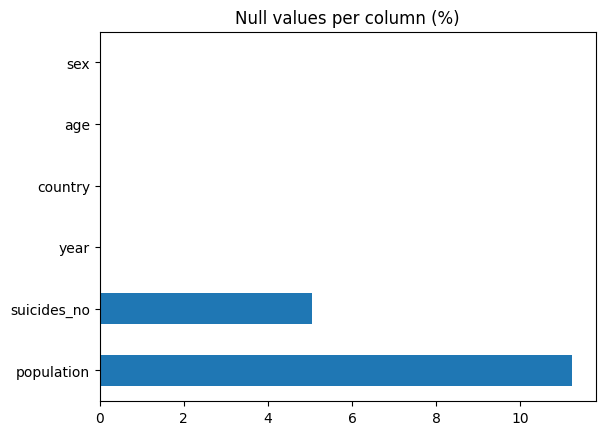

In [134]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False).plot.barh()
plt.title('Null values per column (%)')
plt.show()

In [135]:
df = df.dropna()

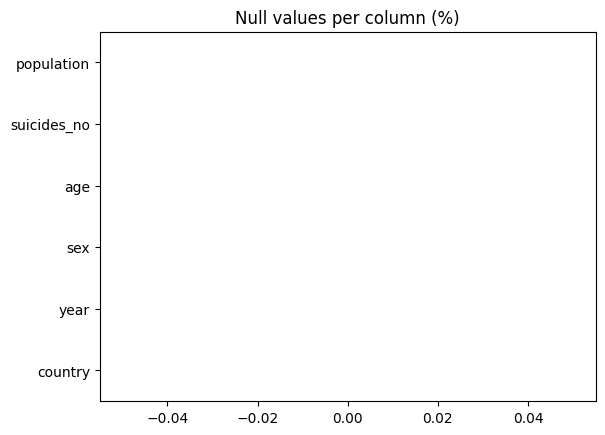

In [136]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False).plot.barh()
plt.title('Null values per column (%)')
plt.show()

In [137]:
print(f"The dataset now contains {df.shape[0]:,} rows (7716 rows dropped)")

The dataset now contains 35,580 rows (7716 rows dropped)


## Any duplicated rows?

In [138]:
df.duplicated().sum()

np.int64(0)

In [139]:
df.dtypes

,0
country,object
year,int64
sex,object
age,object
suicides_no,float64
population,float64


In [140]:
df['sex'].value_counts(normalize=True)

,proportion
sex,
female,0.50
male,0.50


## Columns dtype conversion

In [141]:
df['suicides_no'] = df.loc[:, 'suicides_no'].astype(int)
df['population'] = df.loc[:, 'population'].astype(int)

## New columns

In [142]:
df.loc[:, 'suicides_no/100kpop'] = (df.loc[:, 'suicides_no'] * 100000) / df.loc[:, 'population']

# Ploting and Analysis

## Defining chart colors

In [143]:
COLOR1='#eb6077'
COLOR2='#493443'

## Circular barplot

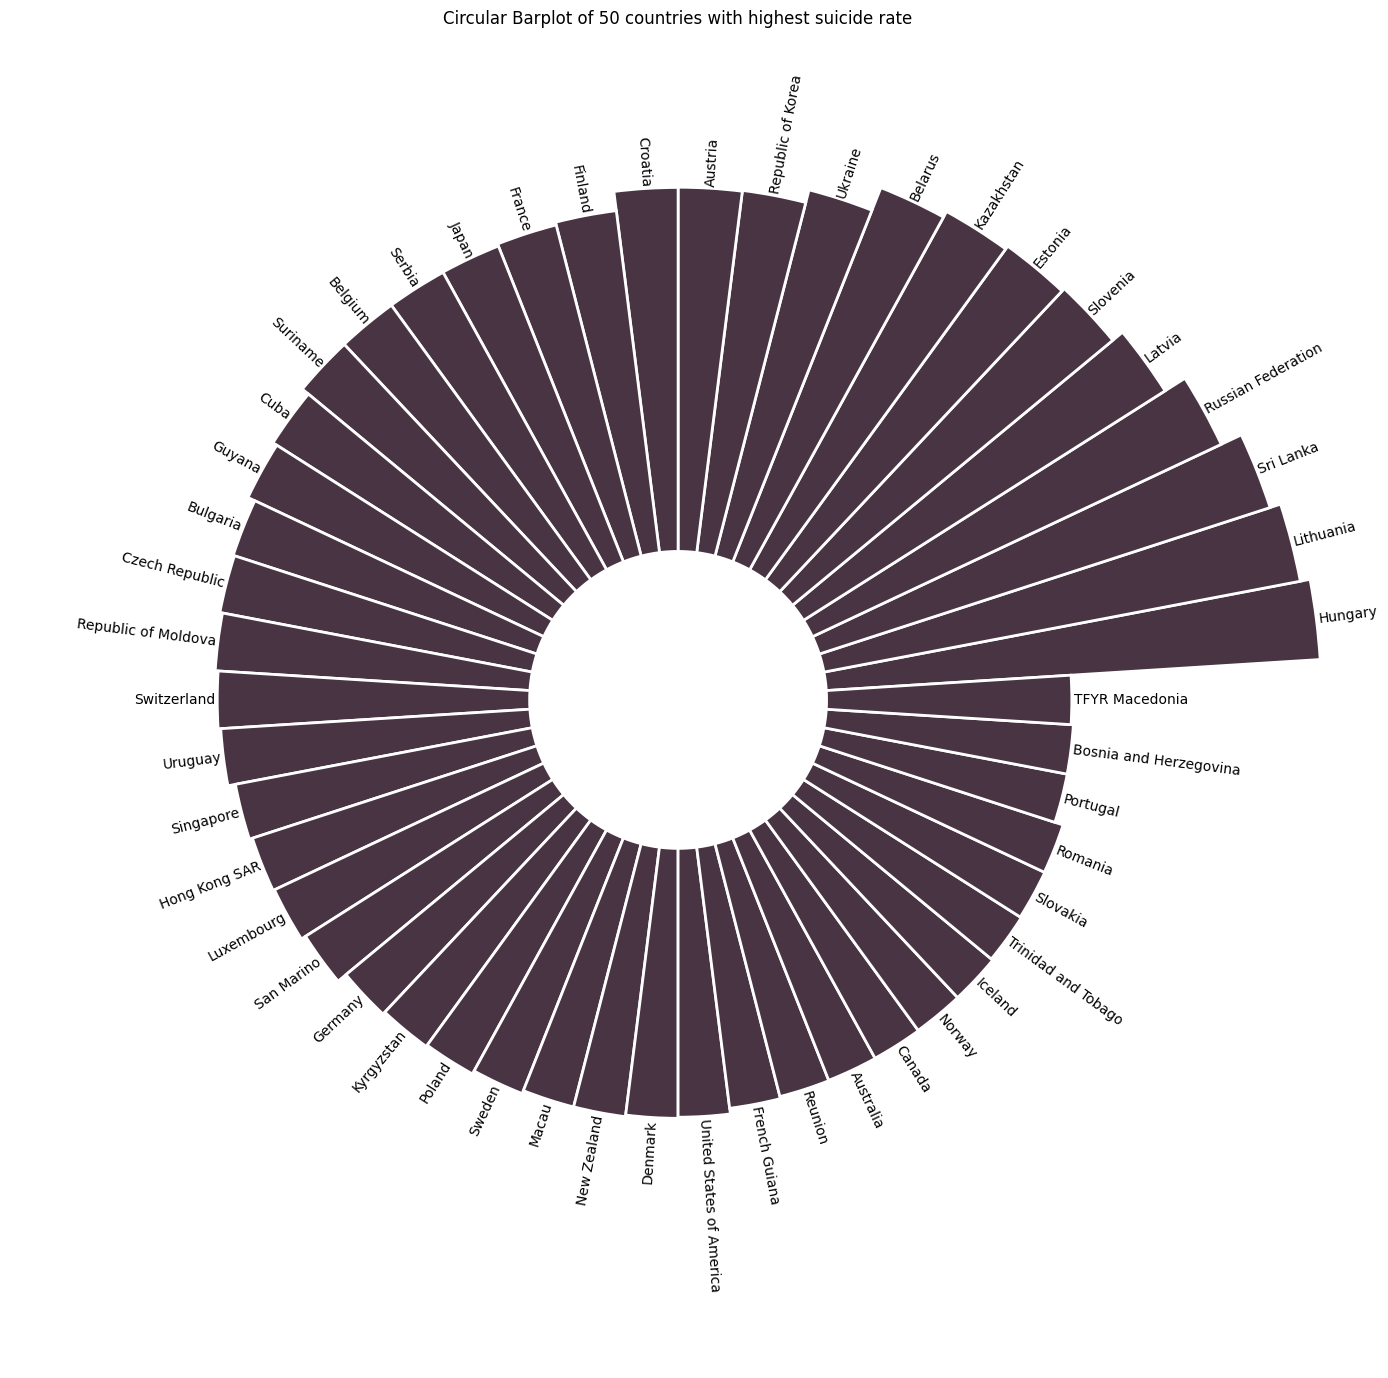

In [144]:
df_grouped = df.groupby('country')['suicides_no/100kpop'].mean().nlargest(50).reset_index()

# set figure size
plt.figure(figsize=(14, 14))

# plot polar axis
ax = plt.subplot(111, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = 1000
lowerLimit = 300

max = df_grouped['suicides_no/100kpop'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (upperLimit - lowerLimit) / max
heights = slope * df_grouped['suicides_no/100kpop'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_grouped.index)

indexes = list(range(1, len(df_grouped.index)+1))
angles = [element * width for element in indexes]

bars = ax.bar(
    x=angles,
    height=heights,
    width=width,
    bottom=lowerLimit,
    linewidth=2,
    edgecolor="white",
    color=COLOR2)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_grouped["country"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle,
        y=lowerLimit + bar.get_height() + labelPadding,
        s=label,
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode="anchor")

plt.title('Circular Barplot of 50 countries with highest suicide rate')
plt.tight_layout()
plt.show()

Plot Analysis:  
An overview of the countries with the highest suicide rates.

## Ploting main function

In [208]:
def plot_suicide_charts(df, groupby_cols, chart_type='line', top_n=None, lowest=False,
                        title_suffix="", color_abs=None, color_rate=None,
                        fig_size=(10, 5), abs_y_lim=None, rate_y_lim=None,
                        abs_x_lim=None, rate_x_lim=None,
                        x_ticks_rotation=45, y_ticks_rotation=45,
                        horizontal=False, space_legend=True):
    """
    Plot absolute and rate suicide charts based on grouping columns.

    Parameters:
    - df: original DataFrame
    - groupby_cols: string or list of columns to group by
    - chart_type: 'line' or 'bar'
    - top_n: for top-N countries, use int and sort values
    - lowest: if True, shows the lowest N instead of highest
    - title_suffix: text to add at the end of the chart title
    - color_abs: color for absolute chart
    - color_rate: color for rate chart
    - fig_size: tuple for figure size
    - abs_y_lim: y-axis limit for absolute chart
    - rate_y_lim: y-axis limit for rate chart
    - x_ticks_rotation: rotation angle for x-axis labels
    - horizontal: if True, plots bar charts in horizontal orientation
    """
    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)

    # Absolute suicides
    df_abs = df.groupby(groupby_cols, observed=True)['suicides_no'].sum().reset_index()
    if top_n:
        df_abs = df_abs.sort_values('suicides_no', ascending=lowest).head(top_n)

    # Rate suicides
    df_rate = df.groupby(groupby_cols, observed=True)['suicides_no/100kpop'].mean().reset_index()
    if top_n:
        df_rate = df_rate.sort_values('suicides_no/100kpop', ascending=lowest).head(top_n)

    # Determine hue and palette
    use_hue = len(groupby_cols) > 1
    hue_col = groupby_cols[1] if use_hue else None
    palette_abs = color_abs if use_hue else None
    palette_rate = color_rate if use_hue else None
    color_abs = None if use_hue else color_abs
    color_rate = None if use_hue else color_rate

    # Plotting
    if chart_type == 'line':
        sns.lineplot(
            data=df_abs, x=groupby_cols[0], y='suicides_no',
            hue=hue_col, ax=ax1,
            color=color_abs, palette=palette_abs
        )
        sns.lineplot(
            data=df_rate, x=groupby_cols[0], y='suicides_no/100kpop',
            hue=hue_col, ax=ax2,
            color=color_rate, palette=palette_rate
        )

    else:
        if horizontal:
            sns.barplot(
                data=df_abs, y=groupby_cols[0], x='suicides_no',
                hue=hue_col, ax=ax1,
                color=color_abs, palette=palette_abs
            )
            sns.barplot(
                data=df_rate, y=groupby_cols[0], x='suicides_no/100kpop',
                hue=hue_col, ax=ax2,
                color=color_rate, palette=palette_rate
            )
        else:
            sns.barplot(
                data=df_abs, x=groupby_cols[0], y='suicides_no',
                hue=hue_col, ax=ax1,
                color=color_abs, palette=palette_abs
            )
            sns.barplot(
                data=df_rate, x=groupby_cols[0], y='suicides_no/100kpop',
                hue=hue_col, ax=ax2,
                color=color_rate, palette=palette_rate
            )

    # Absolute chart config
    ax1.set_title(f"Absolute Suicides {title_suffix}")
    ax1.set_xlabel("" if not horizontal else "Suicides")
    ax1.set_ylabel("" if horizontal else "Suicides")
    if abs_y_lim:
        ax1.set_ylim(abs_y_lim)
    if abs_x_lim:
        ax1.set_xlim(abs_x_lim)
    ax1.tick_params(axis='x' if not horizontal else 'y', rotation=x_ticks_rotation if not horizontal else y_ticks_rotation)

    # Rate chart config
    ax2.set_title(f"Suicide Rate {title_suffix}")
    ax2.set_xlabel("" if not horizontal else "Rate (100kpop)")
    ax2.set_ylabel("" if horizontal else "Rate (100kpop)")
    if rate_y_lim:
        ax2.set_ylim(rate_y_lim)
    if rate_x_lim:
        ax2.set_xlim(rate_x_lim)
    ax2.tick_params(axis='x' if not horizontal else 'y', rotation=x_ticks_rotation if not horizontal else y_ticks_rotation)

    legend = ax1.get_legend()
    if space_legend and legend is not None:
      if(color_abs != color_rate):
        print('To use space_legend, color_abs must be equal to color_rate')
        return

      legend.remove()

      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()


In [221]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_suicide_charts_interactive(df, groupby_cols, chart_type='line', top_n=None, lowest=False,
                                     title_suffix="", color_abs='steelblue', color_rate='indianred',
                                     abs_y_lim=None, rate_y_lim=None, horizontal=False):
    if isinstance(groupby_cols, str):
        groupby_cols = [groupby_cols]

    df_abs = df.groupby(groupby_cols, observed=True)['suicides_no'].sum().reset_index()
    df_rate = df.groupby(groupby_cols, observed=True)['suicides_no/100kpop'].mean().reset_index()

    if top_n:
        df_abs = df_abs.sort_values('suicides_no', ascending=lowest).head(top_n)
        df_rate = df_rate.sort_values('suicides_no/100kpop', ascending=lowest).head(top_n)

    hue_col = groupby_cols[1] if len(groupby_cols) > 1 else None
    x_col = groupby_cols[0]

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f"Absolute Suicides {title_suffix}", f"Suicide Rate {title_suffix}")
    )

    # ABSOLUTE CHART
    if chart_type == 'bar':
        fig.add_trace(
            go.Bar(
                x=df_abs[x_col] if not horizontal else df_abs['suicides_no'],
                y=df_abs['suicides_no'] if not horizontal else df_abs[x_col],
                orientation='h' if horizontal else 'v',
                marker_color=color_abs,
                name='Absolute Suicides',
                hovertemplate=f'{x_col}: %{{x}}<br>Suicides: %{{y}}<extra></extra>' if not horizontal else f'Suicides: %{{x}}<br>{x_col}: %{{y}}<extra></extra>'
            ),
            row=1, col=1
        )
    else:  # line
        fig.add_trace(
            go.Scatter(
                x=df_abs[x_col],
                y=df_abs['suicides_no'],
                mode='lines+markers',
                line=dict(color=color_abs),
                name='Absolute Suicides',
                hovertemplate=f'{x_col}: %{{x}}<br>Suicides: %{{y}}<extra></extra>'
            ),
            row=1, col=1
        )

    # RATE CHART
    if chart_type == 'bar':
        fig.add_trace(
            go.Bar(
                x=df_rate[x_col] if not horizontal else df_rate['suicides_no/100kpop'],
                y=df_rate['suicides_no/100kpop'] if not horizontal else df_rate[x_col],
                orientation='h' if horizontal else 'v',
                marker_color=color_rate,
                name='Suicide Rate',
                hovertemplate=f'{x_col}: %{{x}}<br>Rate: %{{y}}<extra></extra>' if not horizontal else f'Rate: %{{x}}<br>{x_col}: %{{y}}<extra></extra>'
            ),
            row=1, col=2
        )
    else:
        fig.add_trace(
            go.Scatter(
                x=df_rate[x_col],
                y=df_rate['suicides_no/100kpop'],
                mode='lines+markers',
                line=dict(color=color_rate),
                name='Suicide Rate',
                hovertemplate=f'{x_col}: %{{x}}<br>Rate: %{{y}}<extra></extra>'
            ),
            row=1, col=2
        )

    # Set Y-axis limits if provided
    if abs_y_lim:
        fig.update_yaxes(range=abs_y_lim, row=1, col=1)
    if rate_y_lim:
        fig.update_yaxes(range=rate_y_lim, row=1, col=2)

    fig.update_layout(
    title_text=f"Suicide Charts {title_suffix}",
    height=500,
    width=1200,
    template="plotly_white",
    showlegend=True,
    hoverlabel=dict(
        font=dict(color='white'),
        bgcolor='black'
    ),
    # Axis styling for both subplots
    xaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    xaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True),
    yaxis2=dict(showline=True, linewidth=1, linecolor='black', mirror=True)
)




    fig.show()


## Analysing suicide data related to columns

### Year

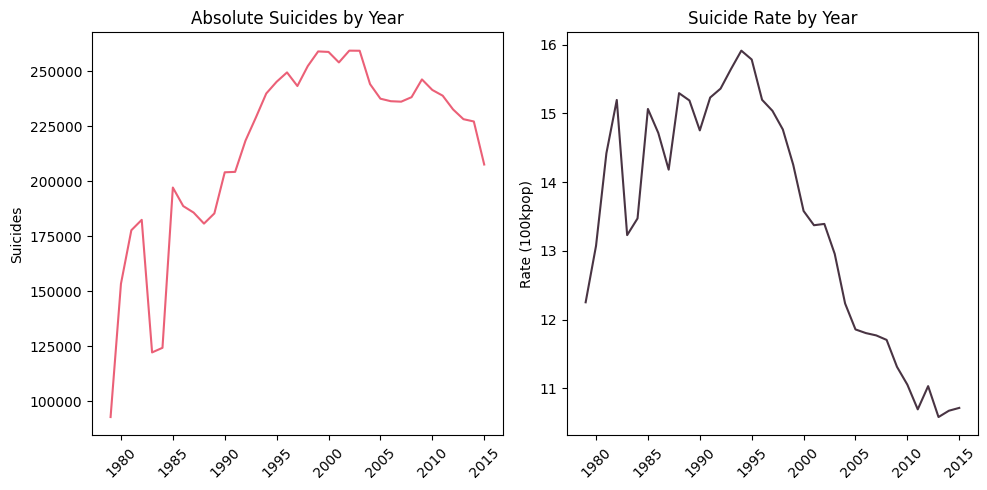

In [217]:
plot_suicide_charts(
    df,
    groupby_cols='year',
    chart_type='line',
    title_suffix="by Year",
    color_abs=COLOR1,
    color_rate=COLOR2
)

In [219]:
plot_suicide_charts_interactive(
    df,
    groupby_cols='year',
    chart_type='line',
    title_suffix="by Year",
    color_abs=COLOR1,
    color_rate=COLOR2
)

Plot Analysis:   
The global number of suicides dropped abruptly from 1982 to 1983.  
The global suicide rate began to decline significantly around 1995.

### Age

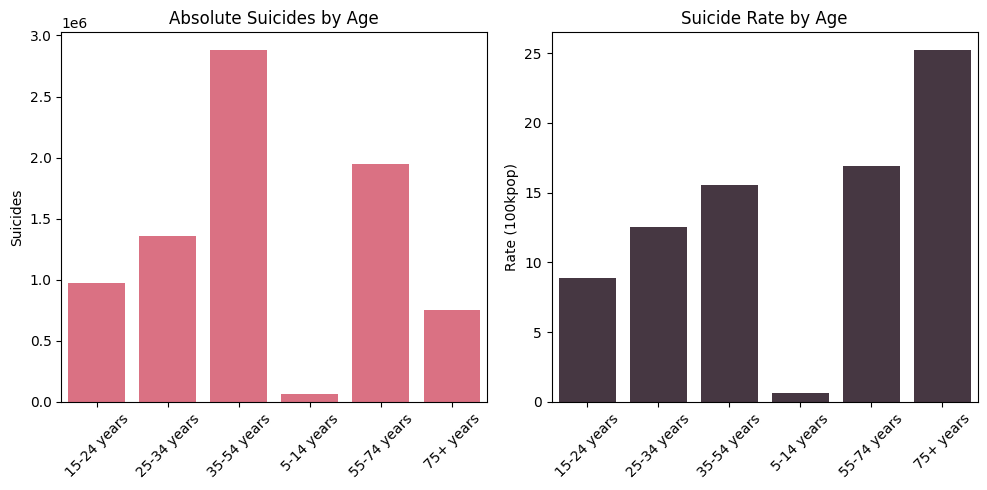

In [147]:
# Suicides by age (bar chart)
plot_suicide_charts(
    df,
    groupby_cols='age',
    chart_type='bar',
    title_suffix="by Age",
    color_abs=COLOR1,
    color_rate=COLOR2,
)

Plot Analysis:   
The majority of global suicides are by adults (35-54 years).  
The global suicide risk increases with age.  

### Sex

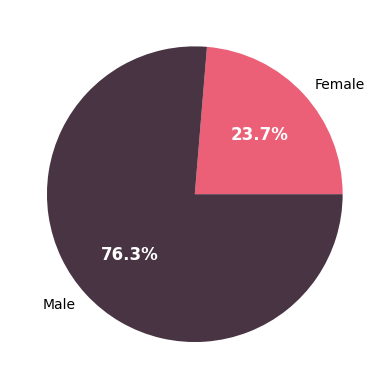

In [153]:
no_female_suicides = df[df['sex'] == 'female']['suicides_no'].sum()
no_male_suicides = df[df['sex'] == 'male']['suicides_no'].sum()

wedges, texts, autotexts = plt.pie([no_female_suicides, no_male_suicides], labels=['Female', 'Male'], autopct='%1.1f%%', wedgeprops={'linewidth': 0}, colors=[COLOR1, COLOR2])

# Style percentages
for t in autotexts:
    t.set_color('white')
    t.set_fontsize(12)
    t.set_fontweight('bold')

plt.show()

In [154]:
ratio = no_male_suicides / no_female_suicides
print(f"Men suicides occurs about {ratio:.2f}x more than women world-wide")

Men suicides occurs about 3.22x more than women world-wide


### Country

#### Highest Suicides Countries

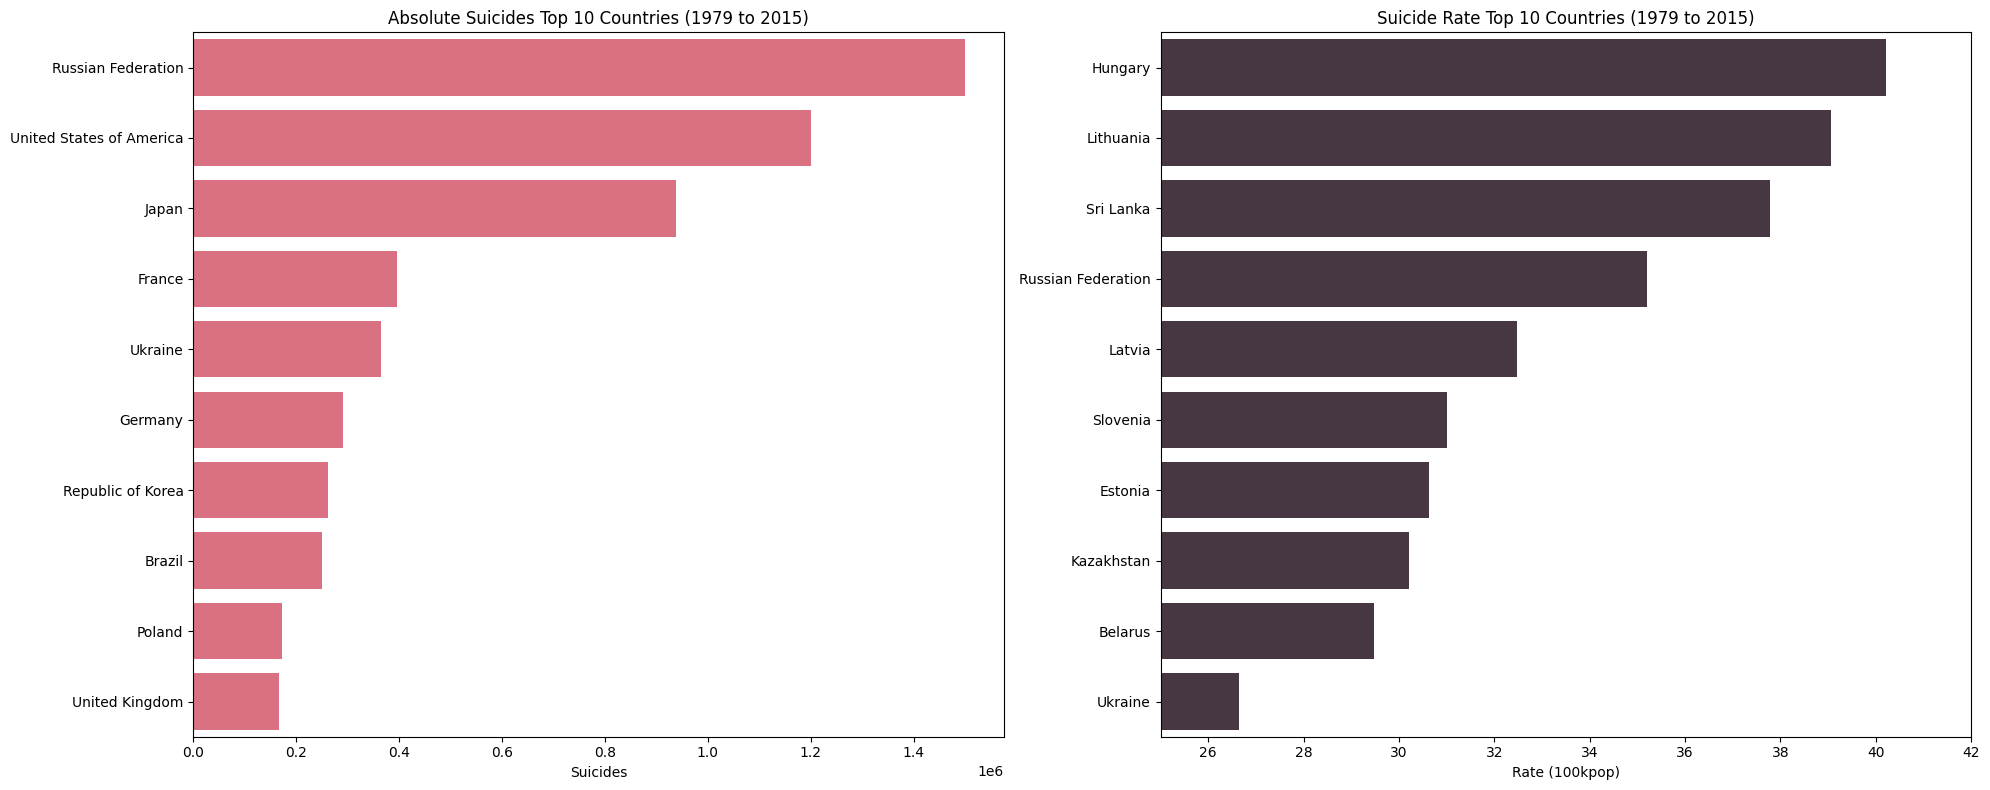

In [148]:
# Top 10 countries with the highest suicide numbers and rates
plot_suicide_charts(
    df,
    groupby_cols='country',
    chart_type='bar',
    top_n=10,
    title_suffix=f"Top 10 Countries ({YEAR_RANGE})",
    color_abs=COLOR1,
    color_rate=COLOR2,
    fig_size=(20, 8),
    y_ticks_rotation=0,
    rate_x_lim=(25, 42),
    horizontal=True,
)

Plot analysis:      
Russia, the USA, and Japan stand out with outlier numbers of suicides.  
Despite having a smaller population than the USA, Russia shows higher absolute suicide numbers, indicating a higher suicide rate. This behavior is also reflected in the suicide rate chart, where Russia appears prominently.  
Japan seems to exhibit a behavior similar to Russia’s, but less pronounced. It does not appear in the suicide rate chart, but if we included more countries, it would probably show up.
Countries with the highest suicide rates are mostly located in Europe and Asia.


#### Lowest Suicides Countries

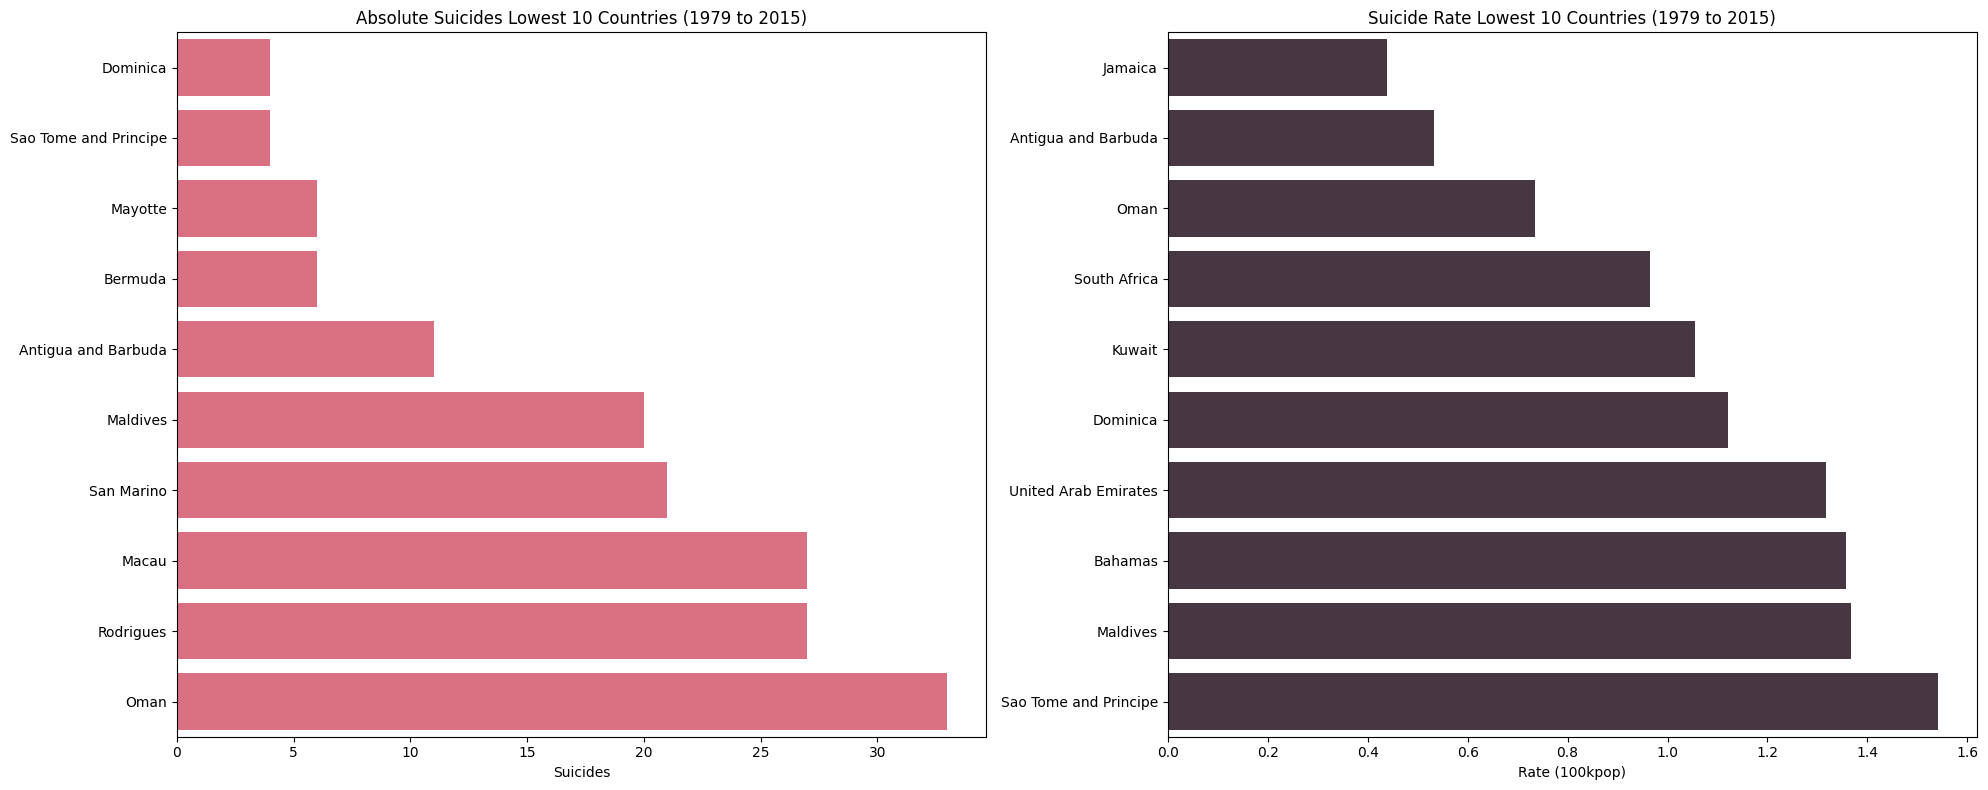

In [149]:
# Top 10 countries with the lowest suicide numbers and rates
plot_suicide_charts(
    df,
    groupby_cols='country',
    chart_type='bar',
    top_n=10,
    lowest=True,
    title_suffix=f"Lowest 10 Countries ({YEAR_RANGE})",
    color_abs=COLOR1,
    color_rate=COLOR2,
    fig_size=(20, 8),
    y_ticks_rotation=0,
    horizontal=True,
)

Plot analysis:  
Countries with the lowest Suicide Rate are mostly in Africa, Caribe and Middle East.  
While these countries report extremely low suicide rates, this may be influenced by a combination of small population sizes, cultural or religious stigma, stronger community ties, and potential underreporting.

### Age - Sex

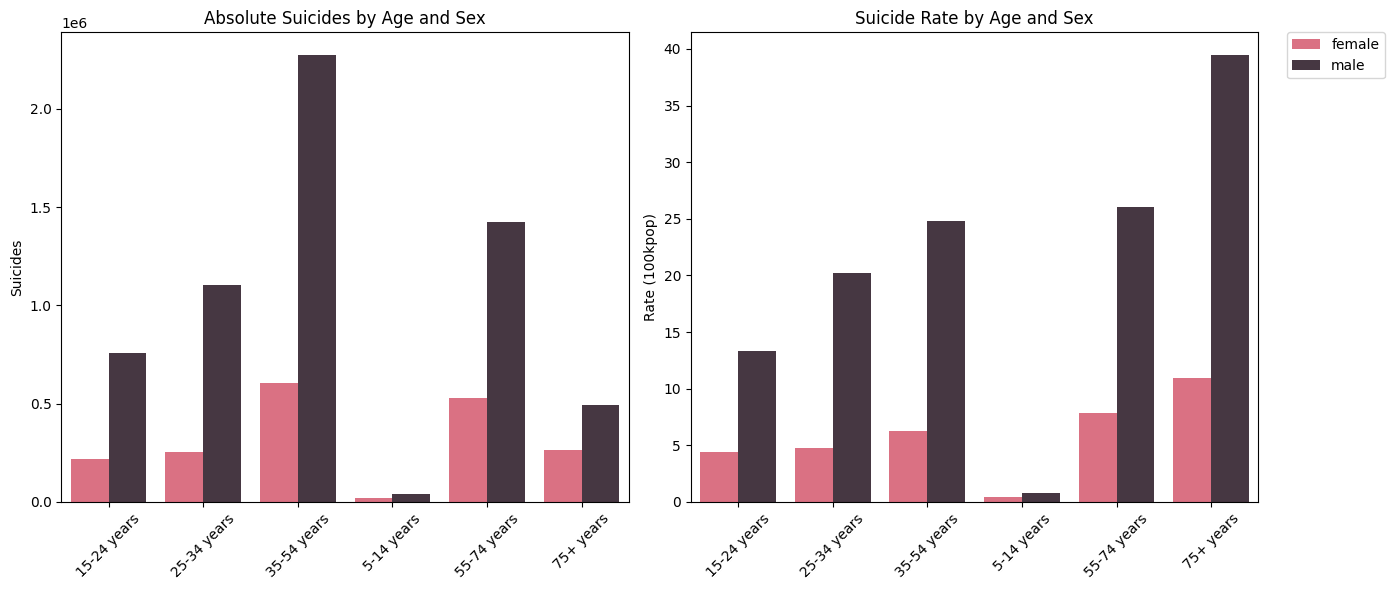

In [150]:
# Suicides by age and sex (bar chart)
plot_suicide_charts(
    df,
    groupby_cols=['age', 'sex'],
    chart_type='bar',
    title_suffix="by Age and Sex",
    fig_size=(14, 6),
    color_abs=[COLOR1, COLOR2],
    color_rate=[COLOR1, COLOR2]
)

Plot Analysis: There aren't a age group that the difference between male and females changes significantly.

### Sex - Year

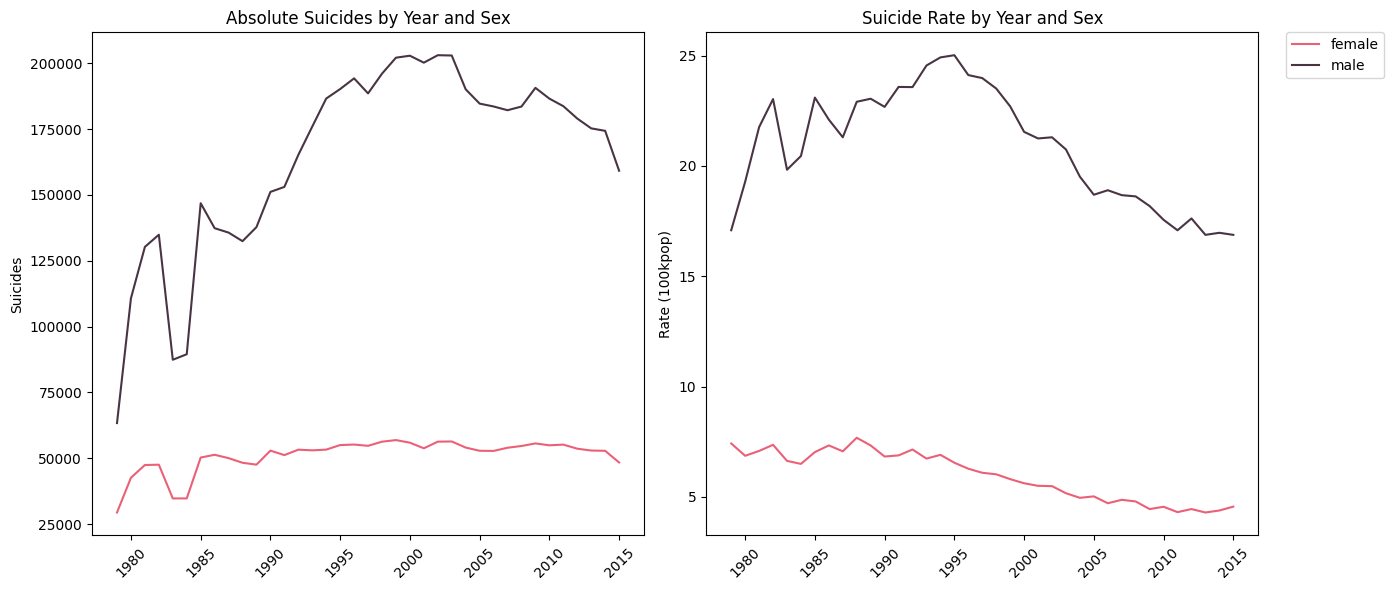

In [151]:
# Suicides by year and sex (line chart)
plot_suicide_charts(
    df,
    groupby_cols=['year', 'sex'],
    chart_type='line',
    title_suffix="by Year and Sex",
    fig_size=(14, 6),
    color_abs=[COLOR1, COLOR2],
    color_rate=[COLOR1, COLOR2]
)

Plot analysis: There isn't a year that females tend to suicide more than males world-wide.

### Year - Country

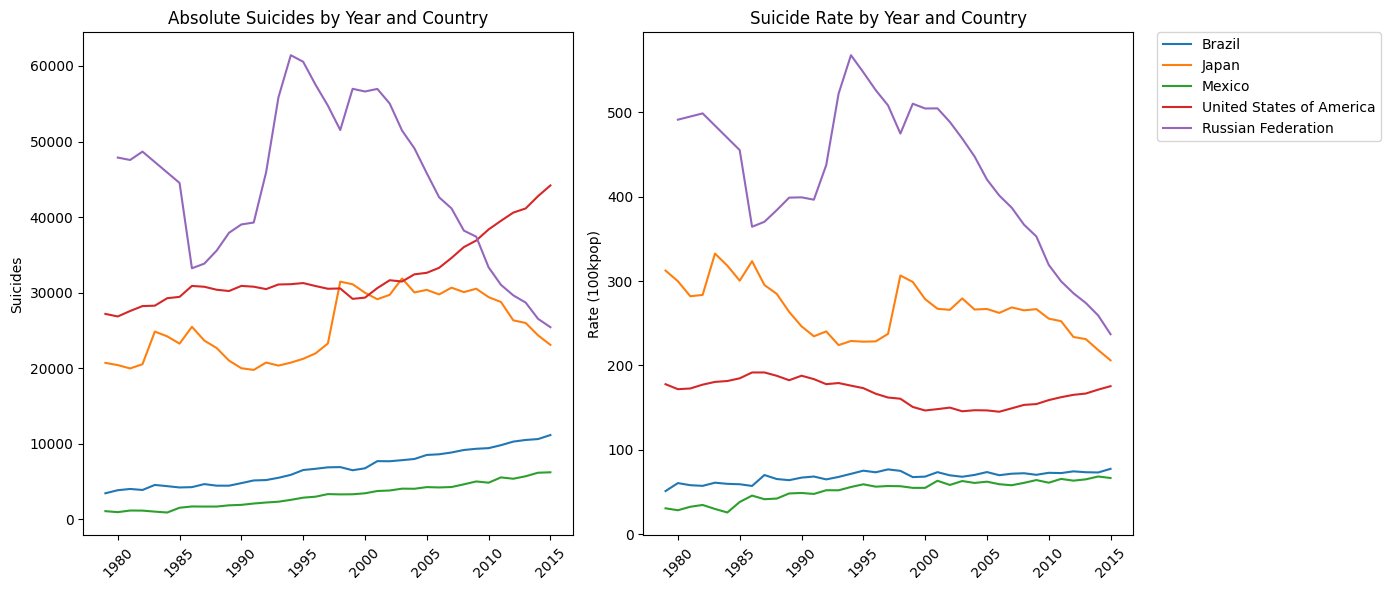

In [152]:
# Suicides by year and country (line chart)

top_5_pop = df.groupby('country', observed=True)['population'].sum().nlargest(5).reset_index()
most_populous_countries = np.array(top_5_pop['country'])

df_full = df.groupby(['country', 'year'], observed=True)[['population', 'suicides_no', 'suicides_no/100kpop']].sum().reset_index()
df_full = df_full[df_full['country'].isin(most_populous_countries)]

plot_suicide_charts(
    df_full,
    groupby_cols=['year', 'country'],
    chart_type='line',
    title_suffix="by Year and Country",
    fig_size=(14, 6),
)

Plot Analysis:  
This rate chart is particularly interesting because it shows a notable difference between Russia, the USA, and Japan (developed countries) and Brazil and Mexico (developing countries).

I believe this behavior is influenced by characteristics specific to these countries:

*   The USA faces issues such as unequal access to mental health care, firearm use, and social isolation.
*   Russia went through severe economic and social crises in the 1990s, marked by increased alcoholism and social disintegration.
*  Japan has a culture of high pressure, long working hours, and a stigma around seeking psychological help.

There is also a broader perspective:

*  Economic development does not guarantee emotional well-being. In developed countries, there is more pressure to perform, social isolation, competitiveness, and sometimes greater individualism.

*  In developing countries, family and community bonds may be stronger, serving as protective factors.


### Year - Age

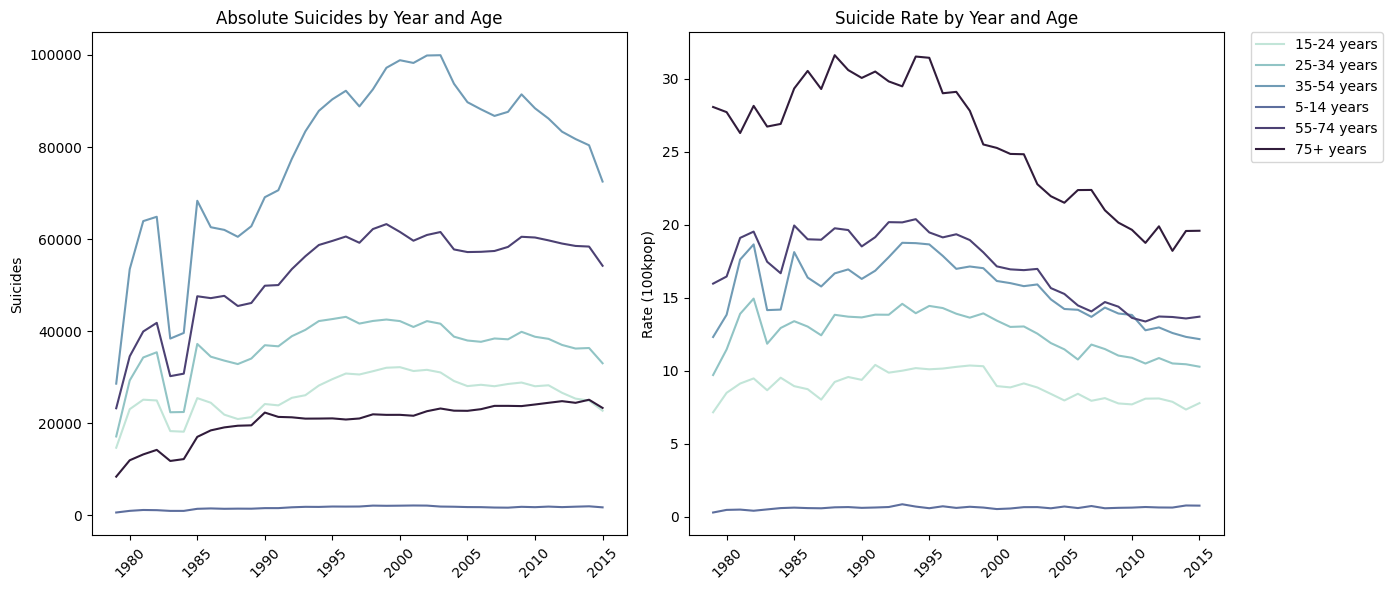

In [155]:
# Suicides by age and year (line chart)
plot_suicide_charts(
    df,
    groupby_cols=['year', 'age'],
    chart_type='line',
    title_suffix="by Year and Age",
    fig_size=(14, 6),
    color_abs=sns.cubehelix_palette(start=.5, rot=-.5),
    color_rate=sns.cubehelix_palette(start=.5, rot=-.5),
)

Plot Analysis: There isn't a year that the one age group act significantly different than the others age-groups.

### Looking at suicide rate more closely

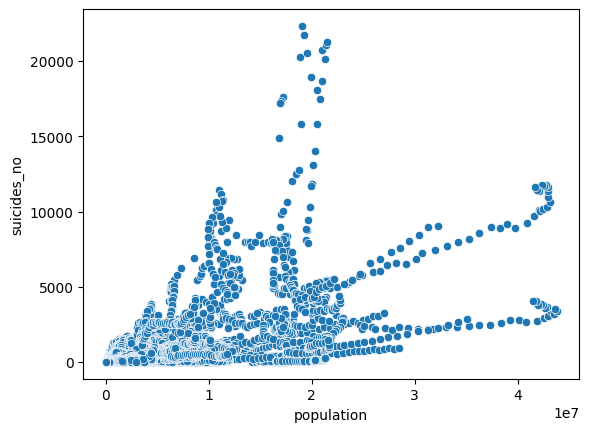

In [156]:
sns.scatterplot(x='population', y='suicides_no', data=df)
plt.show()

Plot Analysis:  
Oh, this chart is quite surprising — it seems that we have three distinct clusters of diverging points when comparing the population and the absolute number of suicides.  
I wonder why this separation is so well-defined...but...

Every point in this chart represent a country, year, sex and age combination.

This bevaviour is not exactly perfect, ideally a point would represent only a country and a year, we can groupby to achieve this:

In [198]:
df_abs = df.groupby(['country', 'year'], observed=True)[['population', 'suicides_no', 'suicides_no/100kpop']].sum().reset_index() # The rate column is not necessary here to plot but we use it later in print_country_info function.

Ok, Every row in this dataframe now contains information about each country-year combination, which is very more accurate.

The plot legend would look quite large because there are too many countries, so let's narrow down our DataFrame to the most populous ones.

In [ ]:
df_abs = df_abs.sort_values(['population'], ascending=False).head(400) # Number of country-year combinations (Decided by experimenting)

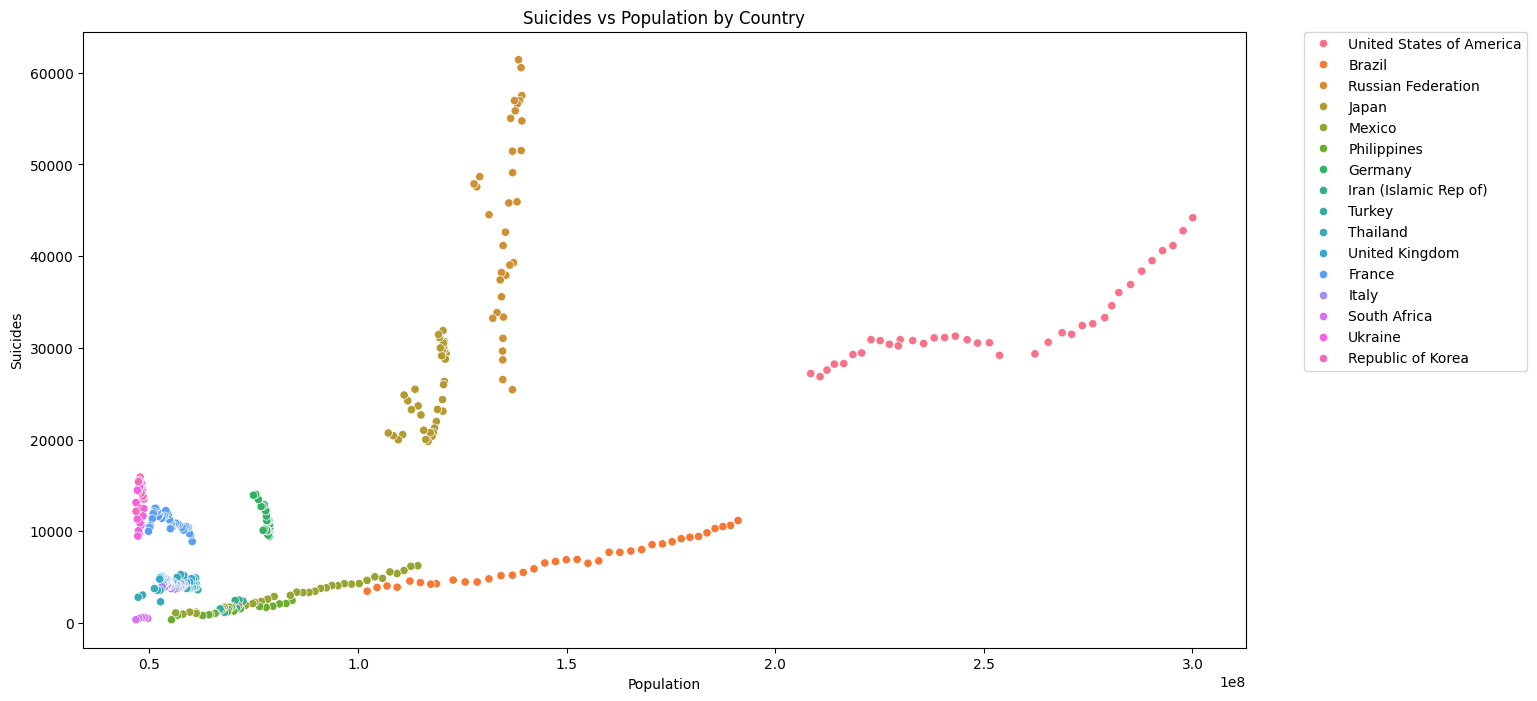

In [199]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x='population', y='suicides_no', hue='country', data=df_abs)
plt.title('Suicides vs Population by Country')
plt.xlabel('Population')
plt.ylabel('Suicides')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Plot Analysis:   
We can see that only 2 of the 3 clusters we had previously seen are actually related to country-year information, regardless of age and sex.  

The cluster that disappeared (the bottom-right one in the first scatter plot) was probably caused by a large population variation within a specific age or sex group in one or more countries over time, which is not relevant to our suicide analysis.

Ok, now we're getting somewhere.
Most countries don't show widely diverging point clusters, because their data over the year are quite uniform, but some countries show points expanding a wide range, that ones are more interesting.

It seems that some of those long lines belong to Russia, USA, Japan, Brazil and Mexico — Russia and Japan appears to have a wide range of suicide counts, while the USA, Brazil and Mexico shows a broad range in population. Let's investigate them further.

### Looking at countries more closely

In [185]:
def plot_country_population(country, color):
    df_country = df_abs[df_abs['country'] == country]
    sns.scatterplot(data=df_country, x='year', y='population', color=color)
    # Suicides by year (line chart)
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title(f"{country}'s Population by Year")
    plt.tight_layout()
    plt.show()

In [203]:
def print_country_info(country):
    df_country = df_abs[df_abs['country'] == country]
    print(f"{country}'s population varied {df_country['population'].max() / df_country['population'].min():.3}-fold from {YEAR_RANGE}.")
    print(f"{country}'s suicides by year varied {df_country['suicides_no'].max() / df_country['suicides_no'].min():.3}-fold from {YEAR_RANGE}.")
    print(f"{country}'s suicide rate varied {df_country['suicides_no/100kpop'].max() / df_country['suicides_no/100kpop'].min():.3}-fold from {YEAR_RANGE}.")

In [177]:
def plot_country_suicide(country, color_abs, color_rate):
    plot_suicide_charts(
          df[df['country'] == country],
          groupby_cols='year',
          chart_type='line',
          title_suffix=f"in {country} by Year",
          color_abs=color_abs,
          color_rate=color_rate,
      )

#### Russia

Russian Federation's population varied 1.09-fold from 1979 to 2015.


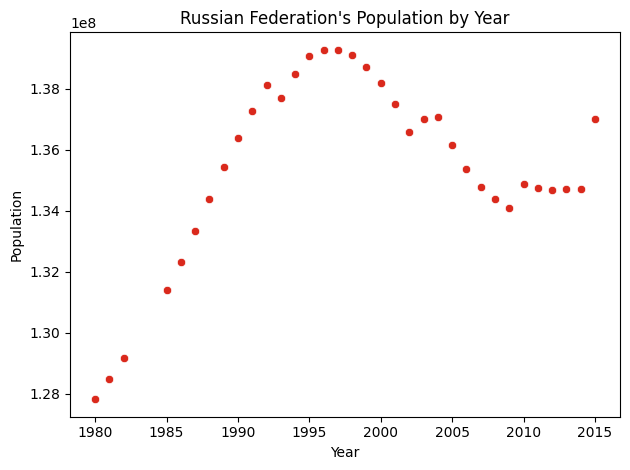

In [184]:
plot_country_population(country='Russian Federation', color='#DA291C')

The Russian population don't substantially changed over these years.

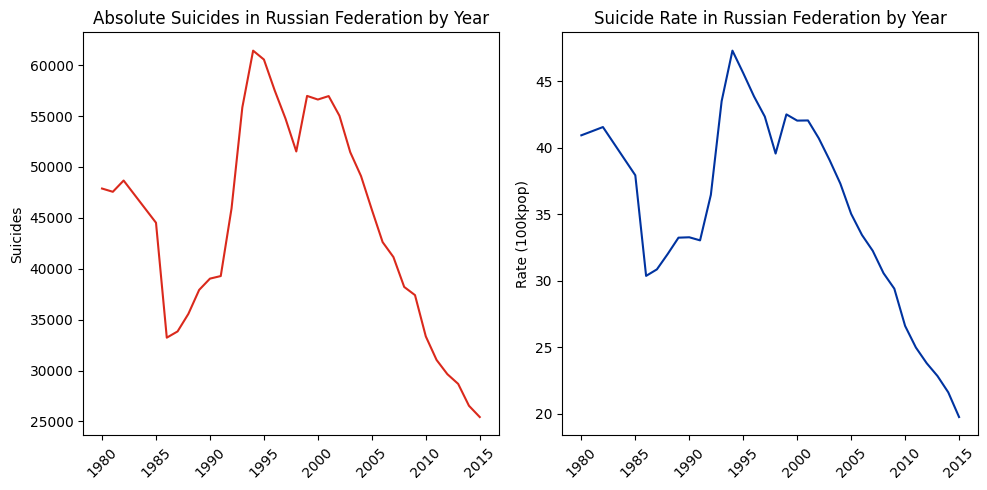

In [179]:
plot_country_suicide(country='Russian Federation', color_abs='#DA291C', color_rate='#0033A0')

But the suicide data vary a lot.

In [194]:
print_country_info('Russian Federation')

Russian Federation's population varied 1.09-fold from 1979 to 2015.
Russian Federation's population varied 2.42-fold from 1979 to 2015.
Russian Federation's population varied 2.4-fold from 1979 to 2015.


Russia Final Analysis:  
Throughout this period, the population did not show a notable difference.  
From 1980 to around 1986, the suicide rate dropped from around 40 to about 30.  
Up to around 1994, it increased, reaching its highest peak above 45.  
Since then, it has been steadily decreasing, reaching around 20 in 2015.  

#### USA

United States of America's population varied 1.44-fold from 1979 to 2015.


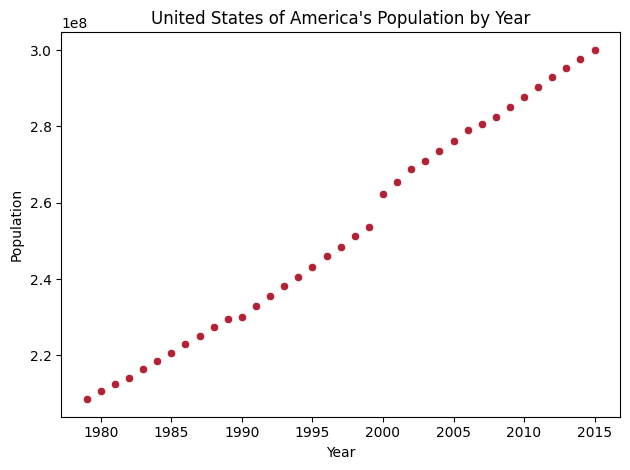

In [163]:
plot_country_population(country='United States of America', color='#B22234')

Ok, so, in fact the American population grows significantly in this period, this quite explain that wide point range.

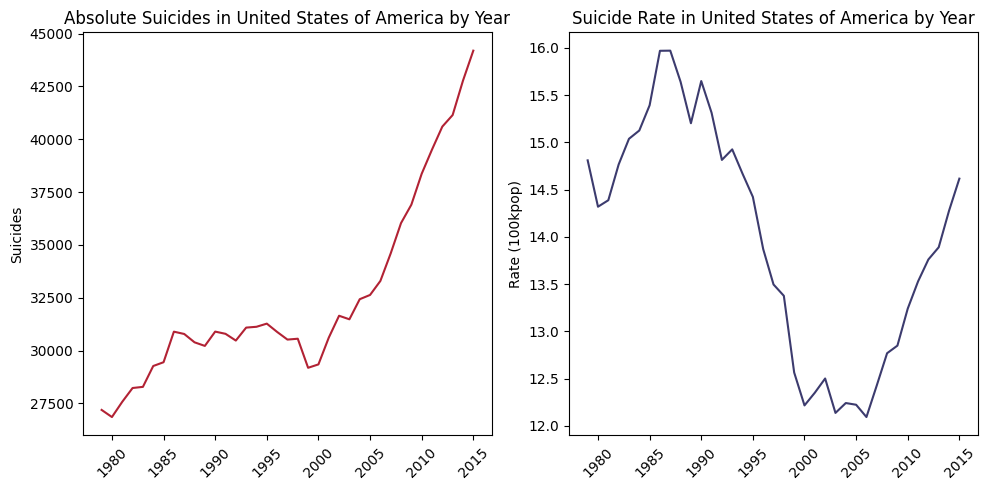

In [180]:
plot_country_suicide(country='United States of America', color_abs='#B22234', color_rate='#3C3B6E')

With population growth, the number of suicides tends to rise as well.  
Looking at this two charts we can see what's happening in the scatter plot one.

In [197]:
print_country_info('United States of America')

United States of America's population varied 1.44-fold from 1979 to 2015.
United States of America's population varied 1.65-fold from 1979 to 2015.
United States of America's population varied 1.32-fold from 1979 to 2015.


USA Final Analysis:  
Throughout this period, the population grew steadily.  
Around the 2000s, the number of suicides began to increase significantly.

#### Japan

Japan's population varied 1.13-fold from 1979 to 2015.


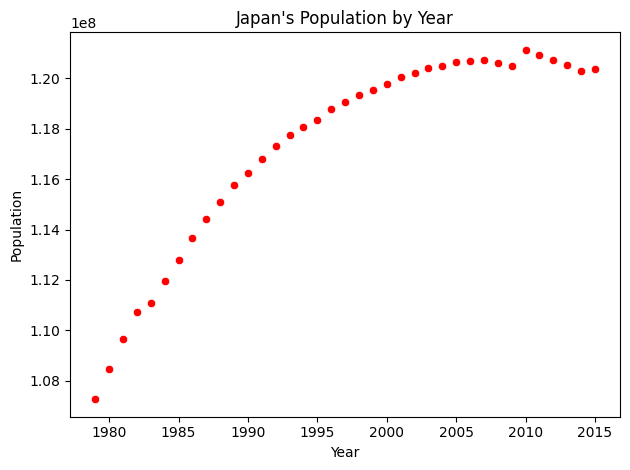

In [165]:
plot_country_population(country='Japan', color='red')

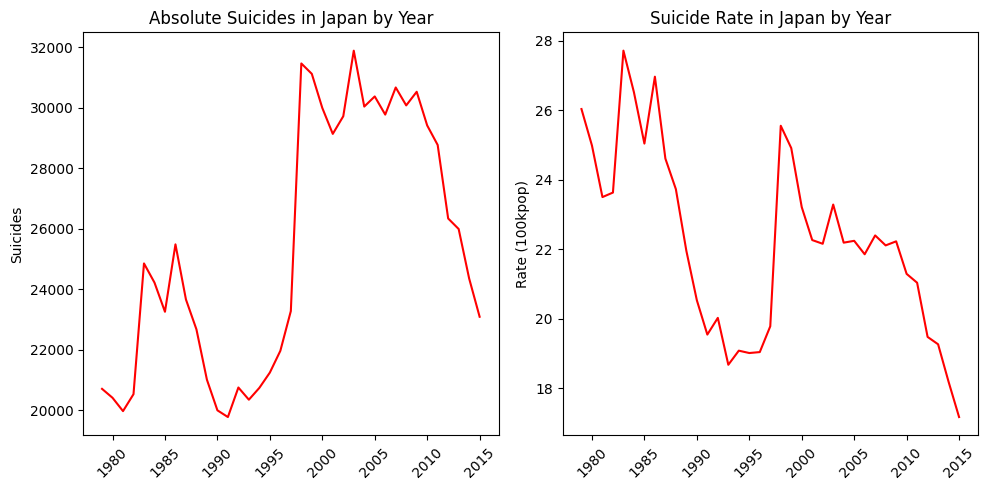

In [181]:
plot_country_suicide(country='Japan', color_abs='red', color_rate='red')

In [200]:
print_country_info('Japan')

Japan's population varied 1.13-fold from 1979 to 2015.
Japan's population varied 1.61-fold from 1979 to 2015.
Japan's population varied 1.61-fold from 1979 to 2015.


Japan Final Analysis:  
Throughout this period, the population does not increases signicantly.
  

#### Brazil

Brazil's population varied 1.87-fold from 1979 to 2015.


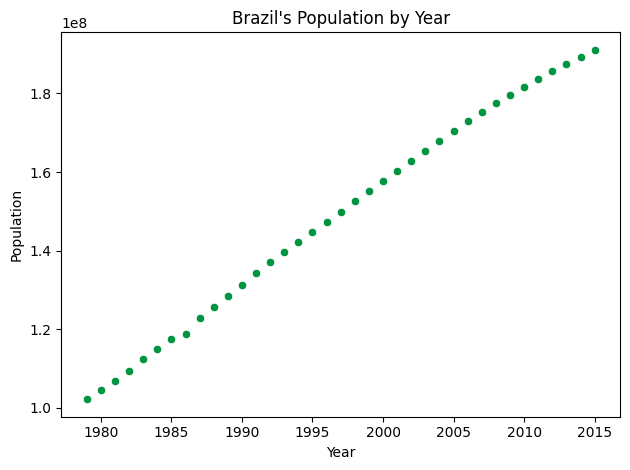

In [167]:
plot_country_population(country='Brazil', color='#009440')

Brazil's population almost doubled in this period.

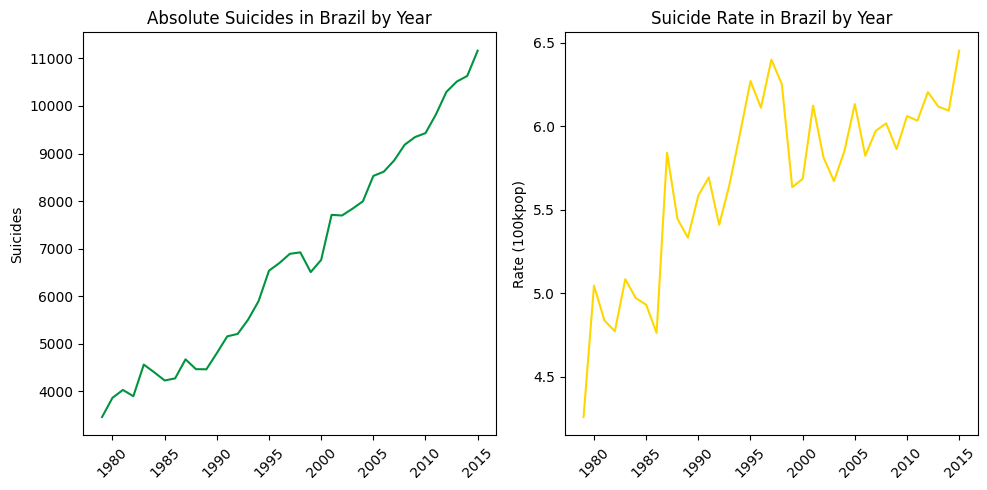

In [182]:
plot_country_suicide(country='Brazil', color_abs='#009440', color_rate='gold')

In [204]:
print_country_info('Brazil')

Brazil's population varied 1.87-fold from 1979 to 2015.
Brazil's suicides by year varied 3.23-fold from 1979 to 2015.
Brazil's suicide rate varied 1.52-fold from 1979 to 2015.


Brazil Final Analysis:  
Throughout this period, both the population and the number of suicide cases grew steadily.  
The suicide rate was somewhat more erratic, but still followed a similar upward trend.

#### Mexico

Mexico's population varied 2.03-fold from 1979 to 2015.


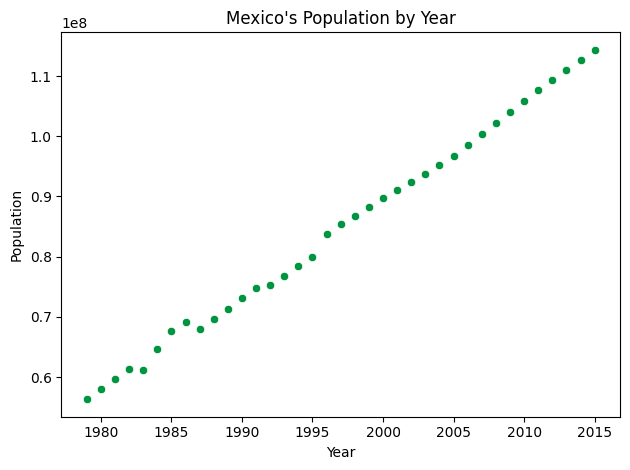

In [175]:
plot_country_population(country='Mexico', color='#009440')

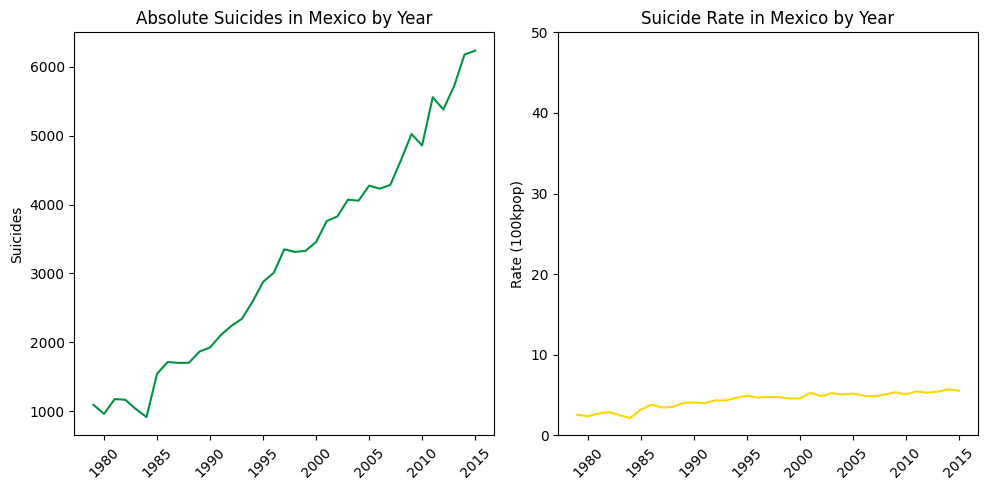

In [176]:
plot_country_suicide(country='Mexico', color_abs='#009440', color_rate='gold')

In [202]:
print_country_info('Mexico')

Mexico's population varied 2.03-fold from 1979 to 2015.
Mexico's population varied 6.81-fold from 1979 to 2015.
Mexico's population varied 2.66-fold from 1979 to 2015.


Mexico Final Analysis:  


# Conclusion